In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from Model_Structure import *

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 18})

c:\Users\14390\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 47, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [5]:
feature_size = 8; hidden_size = 64; num_layers = 2; future_seq_length = 24
tft = TemporalFusionTransformer(feature_size, hidden_size, num_layers, future_seq_length)
tft.load_state_dict(torch.load('Model_Path/TFT.pth'))

Num_Feature = 8; input_size = input_window * Num_Feature; 
theta_size = output_window * Num_Feature; hidden_units = 512; num_blocks = 4
Nbeats = NBeatsModel(num_blocks, input_size, theta_size, hidden_units)
Nbeats.load_state_dict(torch.load('Model_Path/N_BEATS.pth'))

input_dim = 8; output_dim = 8; seq_len = 47
pred_len = 24; d_model = 512; num_heads = 8
INformer = Informer(input_dim, output_dim, seq_len, pred_len, d_model, num_heads)
INformer.load_state_dict(torch.load('Model_Path/Informer.pth'))

input_dim = 8; hidden_dim = 50; num_layers = 2; output_dim = 8
Deepvar = DeepVAR(input_dim, hidden_dim, output_dim, num_layers)
Deepvar.load_state_dict(torch.load('Model_Path/DeepVAR.pth'))

<All keys matched successfully>

In [6]:
# 假设模型已经加载并可用
models = [tft, Nbeats, INformer, Deepvar]

# 初始化权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# weights = nn.Parameter(torch.ones(4, 8) / 4)  # 4个模型，每个模型对8个特征维度有权重
weights = torch.nn.Parameter(torch.full((4, 8), 0.25, device=device))
optimizer = optim.AdamW([weights], lr=0.001, weight_decay=1e-2)
criterion = nn.MSELoss()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def weighted_ensemble_output(models, data, weights, device):
    data = data.to(device)
    weights = weights.to(device)
    with torch.no_grad():
        outputs = torch.stack([model(data) for model in models], dim=0)
        weighted_outputs = torch.einsum('nbfk,nk->bfk', outputs, weights)
    del data, weights, outputs
    torch.cuda.empty_cache() 
    return weighted_outputs

def train_model(train_loader, test_loader, models, weights, optimizer, criterion, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = [model.to(device) for model in models]  # 将所有模型移到设备上
    weights = weights.to(device)  # 确保权重也在正确的设备上
    Best_Loss = 20.0
    Best_Weight = None
    Best_Epoch = None
    writer = SummaryWriter(log_dir='runs/N-BEATS')
    for epoch in range(epochs):
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc='Training', leave=True)
        for inputs, true_outputs in progress_bar:
            inputs, true_outputs = inputs.to(device), true_outputs.to(device)
            optimizer.zero_grad()
            ensemble_output = weighted_ensemble_output(models, inputs, weights, device)
            loss = criterion(ensemble_output, true_outputs)
            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({'loss': loss.item()})
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        test_loss = evaluate_model(test_loader, models, weights, criterion, device)
        if test_loss < Best_Loss:
            Best_Loss = test_loss
            Best_Weight = weights
            Best_Epoch = epoch+1
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return Best_Loss, Best_Weight, Best_Epoch

def evaluate_model(test_loader, models, weights, criterion, device):
    test_loss = 0.0
    with torch.no_grad():
        for inputs, true_outputs in test_loader:
            inputs, true_outputs = inputs.to(device), true_outputs.to(device)
            ensemble_output = weighted_ensemble_output(models, inputs, weights, device)
            loss = criterion(ensemble_output, true_outputs)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

In [20]:
# 运行训练和测试
Best_Loss, Best_Weight, Best_Epoch = train_model(train_loader, test_loader, models, weights, optimizer, criterion, epochs=30)

Training: 100%|██████████| 400/400 [00:29<00:00, 13.44it/s, loss=0.0143] 


Epoch 1/30, Train Loss: 0.0174, Test Loss: 0.0199


Training: 100%|██████████| 400/400 [00:31<00:00, 12.50it/s, loss=0.025]  


Epoch 2/30, Train Loss: 0.0167, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:30<00:00, 13.10it/s, loss=0.0198] 


Epoch 3/30, Train Loss: 0.0165, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.62it/s, loss=0.0121] 


Epoch 4/30, Train Loss: 0.0164, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.62it/s, loss=0.0221] 


Epoch 5/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.73it/s, loss=0.0159] 


Epoch 6/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:30<00:00, 12.91it/s, loss=0.0163] 


Epoch 7/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:30<00:00, 12.94it/s, loss=0.0146] 


Epoch 8/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.70it/s, loss=0.0155] 


Epoch 9/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.76it/s, loss=0.0111] 


Epoch 10/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.66it/s, loss=0.0199] 


Epoch 11/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.63it/s, loss=0.0232] 


Epoch 12/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.74it/s, loss=0.0212] 


Epoch 13/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.59it/s, loss=0.0135] 


Epoch 14/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.68it/s, loss=0.0167] 


Epoch 15/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.61it/s, loss=0.0379] 


Epoch 16/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.69it/s, loss=0.0144] 


Epoch 17/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.64it/s, loss=0.0154] 


Epoch 18/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.60it/s, loss=0.0109] 


Epoch 19/30, Train Loss: 0.0163, Test Loss: 0.0195


Training: 100%|██████████| 400/400 [00:31<00:00, 12.57it/s, loss=0.0213] 


Epoch 20/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.68it/s, loss=0.0167] 


Epoch 21/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.69it/s, loss=0.0114] 


Epoch 22/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.67it/s, loss=0.0105] 


Epoch 23/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.68it/s, loss=0.019]  


Epoch 24/30, Train Loss: 0.0163, Test Loss: 0.0193


Training: 100%|██████████| 400/400 [00:31<00:00, 12.61it/s, loss=0.0122] 


Epoch 25/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.71it/s, loss=0.0173] 


Epoch 26/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.55it/s, loss=0.0126] 


Epoch 27/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.69it/s, loss=0.0199] 


Epoch 28/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.74it/s, loss=0.0141] 


Epoch 29/30, Train Loss: 0.0163, Test Loss: 0.0194


Training: 100%|██████████| 400/400 [00:31<00:00, 12.79it/s, loss=0.0281] 


Epoch 30/30, Train Loss: 0.0163, Test Loss: 0.0194


In [8]:
print(Best_Loss, Best_Weight, Best_Epoch)
torch.save(Best_Weight, 'Model_Path/weights.pth')

NameError: name 'Best_Loss' is not defined

In [7]:
weights = torch.load('Model_Path/weights.pth')

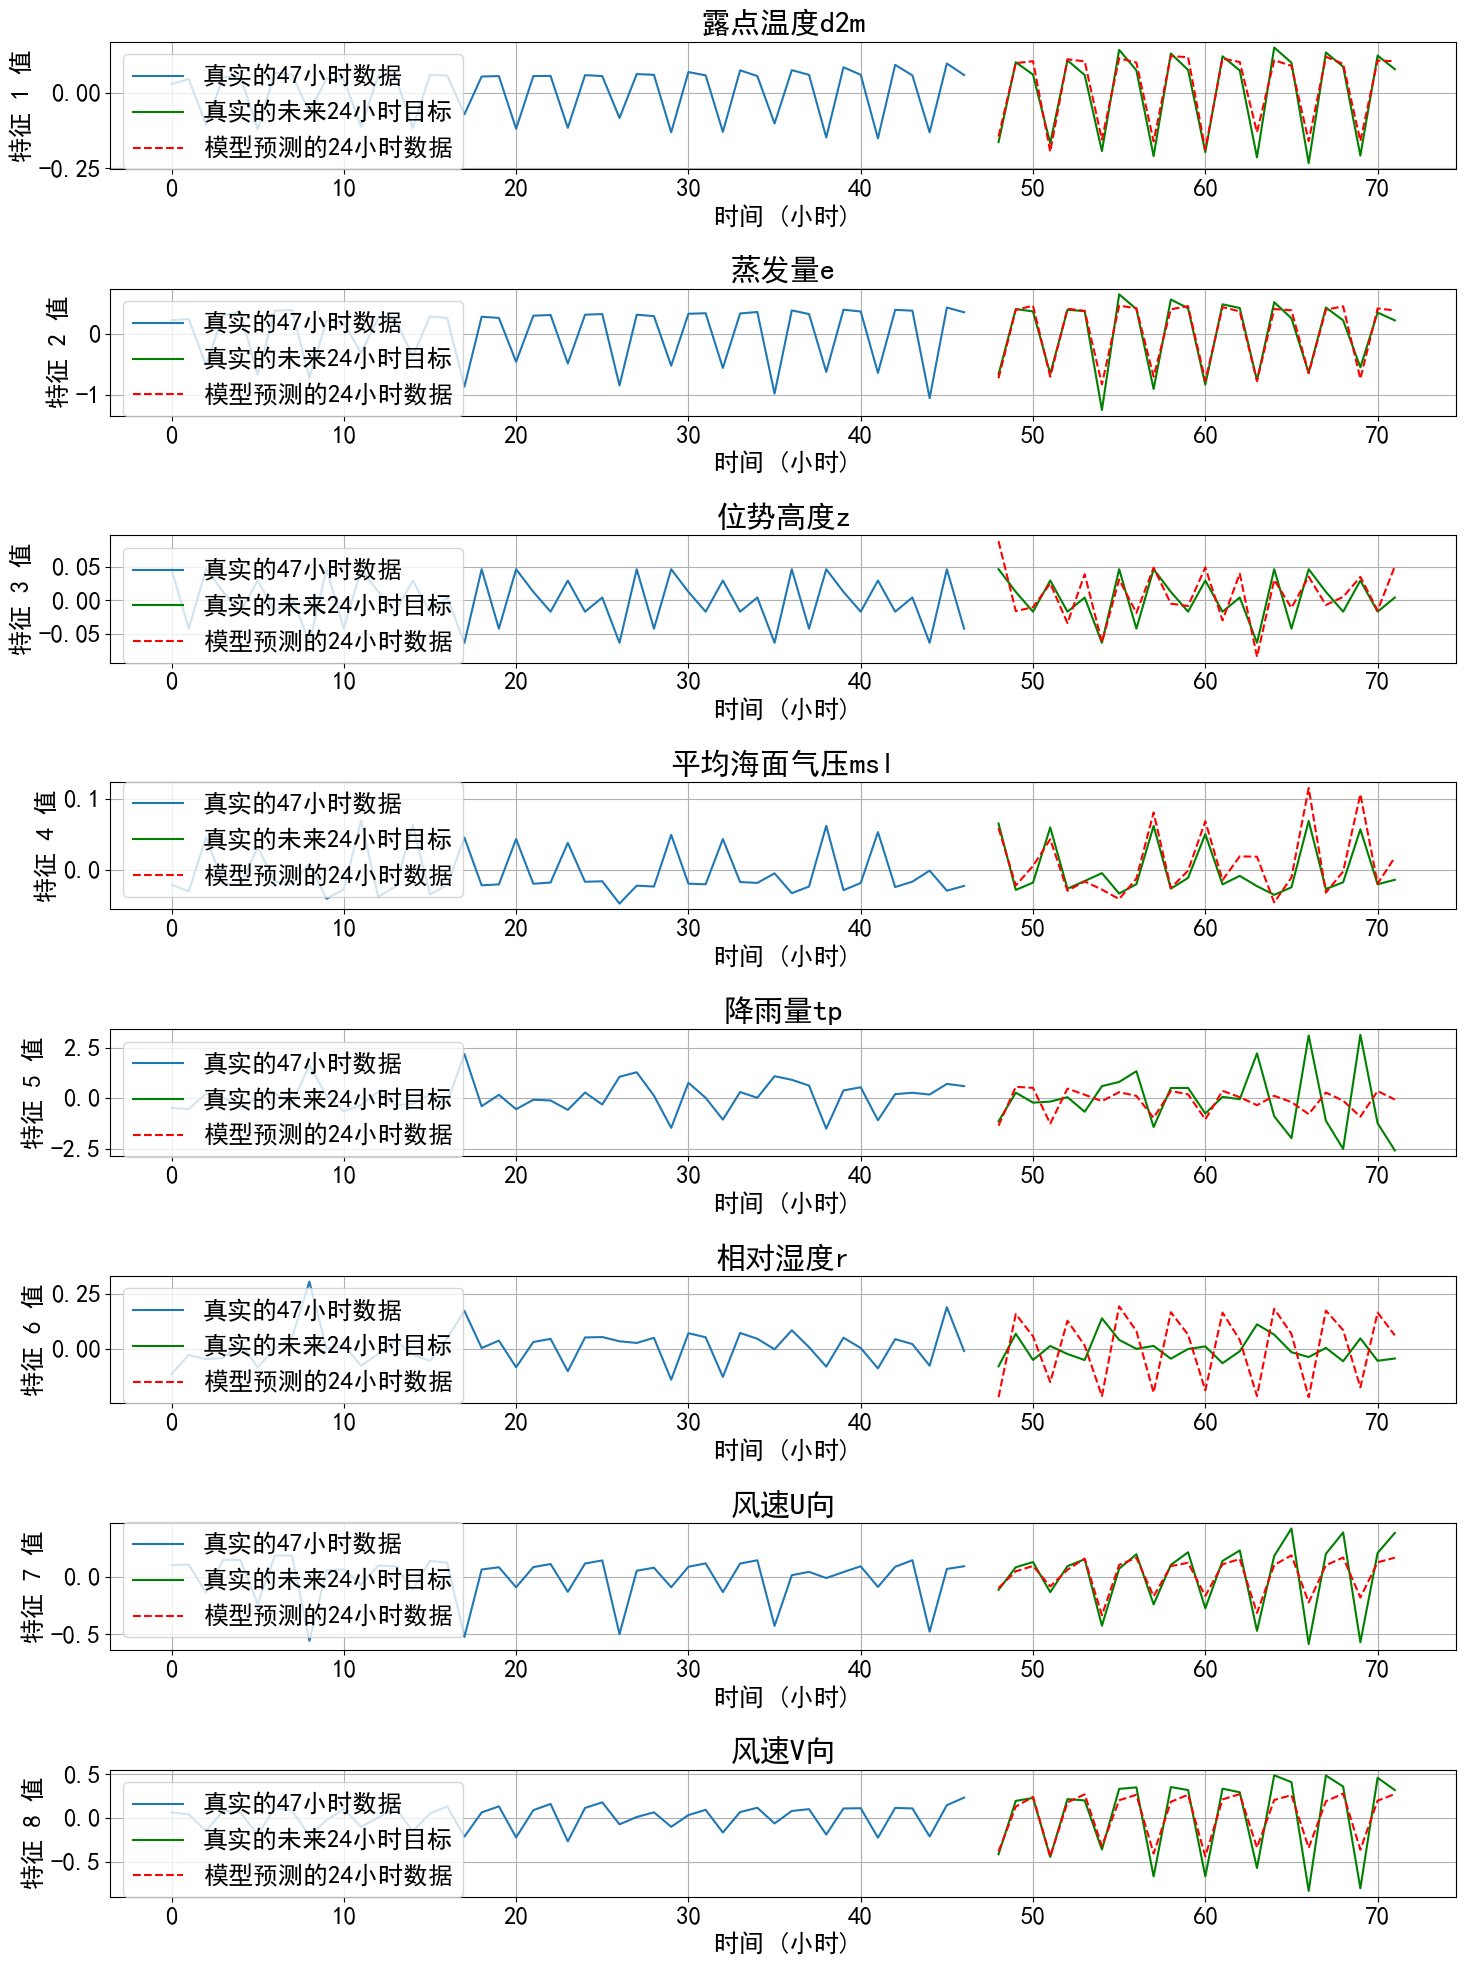

In [10]:
Num_Feature = 8
models = [model.to(device) for model in models]
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']
weights = weights.to(device)
def evaluate_and_plot_features(models, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        # output = predict_future(model, inputs)
        # output = model(inputs)
        inputs = inputs.to(device)
        output = weighted_ensemble_output(models, inputs, weights, device)
        # 选择第一个样本
        single_input = inputs[0:1].to(device)
        single_target = targets[0:1].to(device)
        
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    single_input = single_input.cpu().view(-1, Num_Feature)  # 假设输入有9个特征
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的47小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(variable_names[i])
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征 {i+1} 值')
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(models, test_loader)

In [10]:
Predict_List = []
True_List = []
device = torch.device("cuda")
models = [model.to(device) for model in models]
weights = weights.to(device)
progress_bar = tqdm(train_loader, desc='Train_Loader', leave=True)
for inputs, true_outputs in progress_bar:
    outputs = weighted_ensemble_output(models, inputs, weights, device)
    Predict_List.append(outputs)
    True_List.append(true_outputs)

Train_Loader: 100%|██████████| 400/400 [00:16<00:00, 24.09it/s]


In [11]:
progress_bar = tqdm(test_loader, desc='Test_Loader', leave=True)
for inputs, true_outputs in progress_bar:
    outputs = weighted_ensemble_output(models, inputs, weights, device)
    Predict_List.append(outputs)
    True_List.append(true_outputs)

Test_Loader: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


In [12]:
Predict_Value = torch.cat(Predict_List, dim=0).cpu().detach().numpy()
True_Value = torch.cat(True_List, dim=0).cpu().detach().numpy()
print(Predict_Value.shape, True_Value.shape)

(90000, 24, 8) (90000, 24, 8)


In [13]:
Diff_Value = (True_Value - Predict_Value)
print(Diff_Value.shape)

(90000, 24, 8)


In [14]:
np.savez('DataSet/Diff_GCN.npz', features = Predict_Value, labels=Diff_Value)

In [15]:
np.savez('DataSet/Diff_GCN_2.npz', features = Predict_Value, labels=True_Value)